# Data Context
The dataset consists of two datasets from rijdendetreinen.nl, the services dataset from 2019-2024 and the disruption datasets from these same years. These datasets have been appended and transformed so we have a daily overview over wether a trajectory has been disrupted that day. Additionally, the daily weather data has been sourced from KNMI, for a few different weather stations. This has been merged with the daily trajectory dataset based on the closest weather station to the source of the trajectory. For the train stations coordinates, the stations-2019-nl dataset has been used, also provided by rijdendetreinen.nl.

The main dataset has already been proprocessed, all the trajectories have been grouped by day, the daily weather data has been added. Apart from the data, origin and destination of each trajectory, the dataset contains the number of rides planned, the total final arrival delay of that day, the amount of times a final arrival heas been cancelled, the amount of times the trajectory has been completely cancelled and the total amount of intermediate arrival delays. From the disruptions dataset, a list of the statistical causes of the disruptions that occured that day has been added, as well as the total amount of disruptions that day and a binary variable that is true if the trajectory has been disrupted at least once that day. The added weather variables are:

FHVEC     : Vector mean windspeed (in 0.1 m/s)<br>
TG        : Daily mean temperature in (0.1 degrees Celsius<br>
TN        : Minimum temperature (in 0.1 degrees Celsius)<br>
TX        : Maximum temperature (in 0.1 degrees Celsius)<br>
T10N      : Minimum temperature at 10 cm above surface (in 0.1 degrees Celsius)<br>
SQ        : Sunshine duration (in 0.1 hour) calculated from global radiation (-1 for <0.05 hour)<br>
DR        :Precipitation duration (in 0.1 hour)<br>
RH        : Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)<br>
RHX       : Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)<br>
VVX       : Maximum visibility <br>


# Data Description

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

### Data Loading

In [6]:
# Load main dataset
disruptions_df = pd.read_csv('daily_disruptions_weather.csv')
disruptions_df['Date'] = pd.to_datetime(disruptions_df['Date'])

# Load data necessary for graph
coordinates_df = pd.read_csv('stations-2023-09-nl.csv')
distances_df = pd.read_csv('station_distances.csv')

# Merge distance data
disruptions_df = disruptions_df.merge(
    distances_df, 
    how='left', 
    left_on=['source', 'target'], 
    right_on=['origin_name', 'destination_name']
)
# Strip column names to remove leading/trailing spaces
disruptions_df.columns = disruptions_df.columns.str.strip()
# disruptions_df['distance'] = disruptions_df['distance'].fillna(0)
disruptions_df = disruptions_df.drop(columns=['Unnamed: 0','origin_name', 'destination_name'])
disruptions_df = disruptions_df.dropna(subset=['SQ', 'distance'], how='all')
valid_stations = set(coordinates_df['name_long'])
# Filter out rows where both source and target are not in valid stations
disruptions_df = disruptions_df[~(disruptions_df['distance'].isna() & (~disruptions_df['source'].isin(valid_stations) | ~disruptions_df['target'].isin(valid_stations)))]
# Convert weather columns to float
columns_to_convert = ['DR', 'RH', 'SQ', 'TG', 'TN', 'TX', 'RHX', 'VVX', 'T10N', 'FHVEC']

# Clean the data: strip spaces and coerce non-numeric values to NaN
disruptions_df[columns_to_convert] = disruptions_df[columns_to_convert].applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
disruptions_df[columns_to_convert] = disruptions_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Check for columns with NaN values
nan_columns = disruptions_df.columns[disruptions_df.isna().any()].tolist()

for col in nan_columns:
    disruptions_df[col] = disruptions_df[col].fillna(disruptions_df[col].median())
# Ensure 'Statistical Causes' is a string before applying eval
disruptions_df['Statistical Causes'] = disruptions_df['Statistical Causes'].apply(
    lambda x: eval(x) if isinstance(x, str) and x != 'No Disruption' else x
)
disruptions_df

C:\Users\EduardCP\AppData\Local\Temp\ipykernel_4236\2271878716.py:2: DtypeWarning: Columns (10,11,12,13,14,15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  disruptions_df = pd.read_csv('daily_disruptions_weather.csv')
C:\Users\EduardCP\AppData\Local\Temp\ipykernel_4236\2271878716.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  disruptions_df[columns_to_convert] = disruptions_df[columns_to_convert].applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,SQ,TG,TN,TX,RHX,VVX,T10N,FHVEC,Disrupted,distance
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,No Disruption,0.0,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,False,62.0
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,No Disruption,0.0,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,False,108.0
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,No Disruption,0.0,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,False,54.0
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,No Disruption,0.0,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,False,73.0
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,No Disruption,0.0,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,False,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654431,2024-12-31,Zwolle,Nijmegen,1,0,0,0,1,No Disruption,0.0,...,0.0,52.0,29.0,79.0,-1.0,80.0,29.0,82.0,False,95.0
654432,2024-12-31,Zwolle,Roosendaal,31,5,6,0,28,No Disruption,0.0,...,0.0,52.0,29.0,79.0,-1.0,80.0,29.0,82.0,False,201.0
654433,2024-12-31,Zwolle,Schiphol Airport,1,0,0,0,0,No Disruption,0.0,...,0.0,52.0,29.0,79.0,-1.0,80.0,29.0,82.0,False,121.0
654434,2024-12-31,Zwolle,Utrecht Centraal,29,1,0,0,19,No Disruption,0.0,...,0.0,52.0,29.0,79.0,-1.0,80.0,29.0,82.0,False,87.0


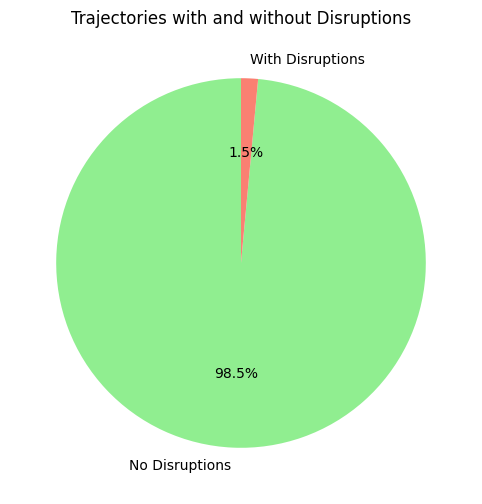

In [7]:
import matplotlib.pyplot as plt

# Count the number of trajectories with Disruption Count == 0 and > 0
disrupted = (disruptions_df["Disrupted"] == True).sum()
non_disrupted =  (disruptions_df["Disrupted"] == False).sum()

# Data for the pie chart
labels = ['No Disruptions', 'With Disruptions']
sizes = [non_disrupted, disrupted]
colors = ['lightgreen', 'salmon']

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Trajectories with and without Disruptions')
plt.show()

In [27]:
# Define conditions
# Handle boolean or numeric columns
condition1 = disruptions_df['Final arrival cancelled'].astype(int) > 0  # Convert boolean to int if needed
condition2 = disruptions_df['Completely cancelled'].astype(int) > 0
condition3 = disruptions_df['Disruption Count'] == 0

# Combine conditions
mask = condition1 & condition2 & condition3

# Set Disrupted to True where conditions are met
disruptions_df.loc[mask, 'Disrupted'] = True
disruptions_df.loc[mask, 'Disruption Count'] = disruptions_df['Final arrival cancelled']
disruptions_df.loc[mask, 'Statistical Causes'] = [ ['Unspecified'] for _ in range(mask.sum()) ]

In [29]:
disruptions_df[disruptions_df['Disrupted'] == True] 

,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,VVX,T10N,FHVEC,Disrupted,distance,YearMonth,Year,Month,Day,Season
5,2019-01-01,'s-Hertogenbosch,Roosendaal,2,0,1,1,0,Unspecified,1.0,...,74.0,28.0,40.0,True,67.0,2019-01,2019,1,1,Winter
6,2019-01-01,'s-Hertogenbosch,Utrecht Centraal,1,0,0,0,1,"[damaged overhead wires, an emergency call]",2.0,...,74.0,28.0,40.0,True,48.0,2019-01,2019,1,1,Winter
72,2019-01-01,Den Haag Centraal,Eindhoven Centraal,32,4,1,1,18,Unspecified,1.0,...,76.0,50.0,52.0,True,131.0,2019-01,2019,1,1,Winter
79,2019-01-01,Den Haag Centraal,Utrecht Centraal,21,2,1,0,4,[broken down train],1.0,...,76.0,50.0,52.0,True,60.0,2019-01,2019,1,1,Winter
101,2019-01-01,Eindhoven Centraal,Den Haag Centraal,32,11,2,2,24,Unspecified,1.0,...,74.0,28.0,40.0,True,131.0,2019-01,2019,1,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654318,2024-12-31,Lelystad Centrum,Rotterdam Centraal,13,3,1,1,10,Unspecified,1.0,...,80.0,29.0,82.0,True,127.0,2024-12,2024,12,31,Winter
654361,2024-12-31,Rotterdam Centraal,Lelystad Centrum,15,1,2,2,5,Unspecified,1.0,...,68.0,30.0,80.0,True,127.0,2024-12,2024,12,31,Winter
654363,2024-12-31,Rotterdam Centraal,Utrecht Centraal,61,11,1,1,37,[broken down train],1.0,...,68.0,30.0,80.0,True,56.0,2024-12,2024,12,31,Winter
654379,2024-12-31,Uitgeest,Rotterdam Centraal,27,3,1,1,20,Unspecified,1.0,...,73.0,34.0,89.0,True,86.0,2024-12,2024,12,31,Winter


### Data Imbalance

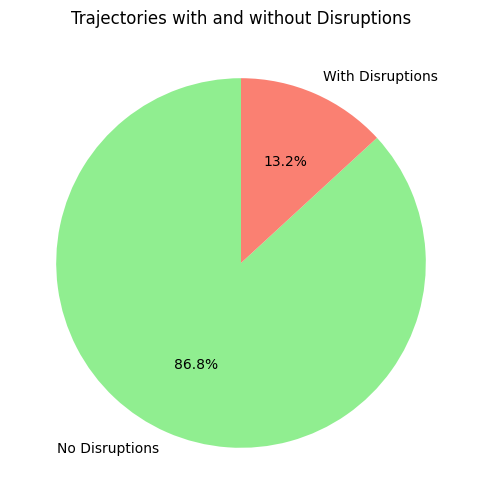

In [30]:
import matplotlib.pyplot as plt

# Count the number of trajectories with Disruption Count == 0 and > 0
disrupted = (disruptions_df["Disrupted"] == True).sum()
non_disrupted =  (disruptions_df["Disrupted"] == False).sum()

# Data for the pie chart
labels = ['No Disruptions', 'With Disruptions']
sizes = [non_disrupted, disrupted]
colors = ['lightgreen', 'salmon']

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Trajectories with and without Disruptions')
plt.show()

## Most Common Statistical Causes Over Time

C:\Users\brake\AppData\Local\Temp\ipykernel_33940\979378941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disrupted_df['Year'] = pd.to_datetime(disrupted_df['Date']).dt.year


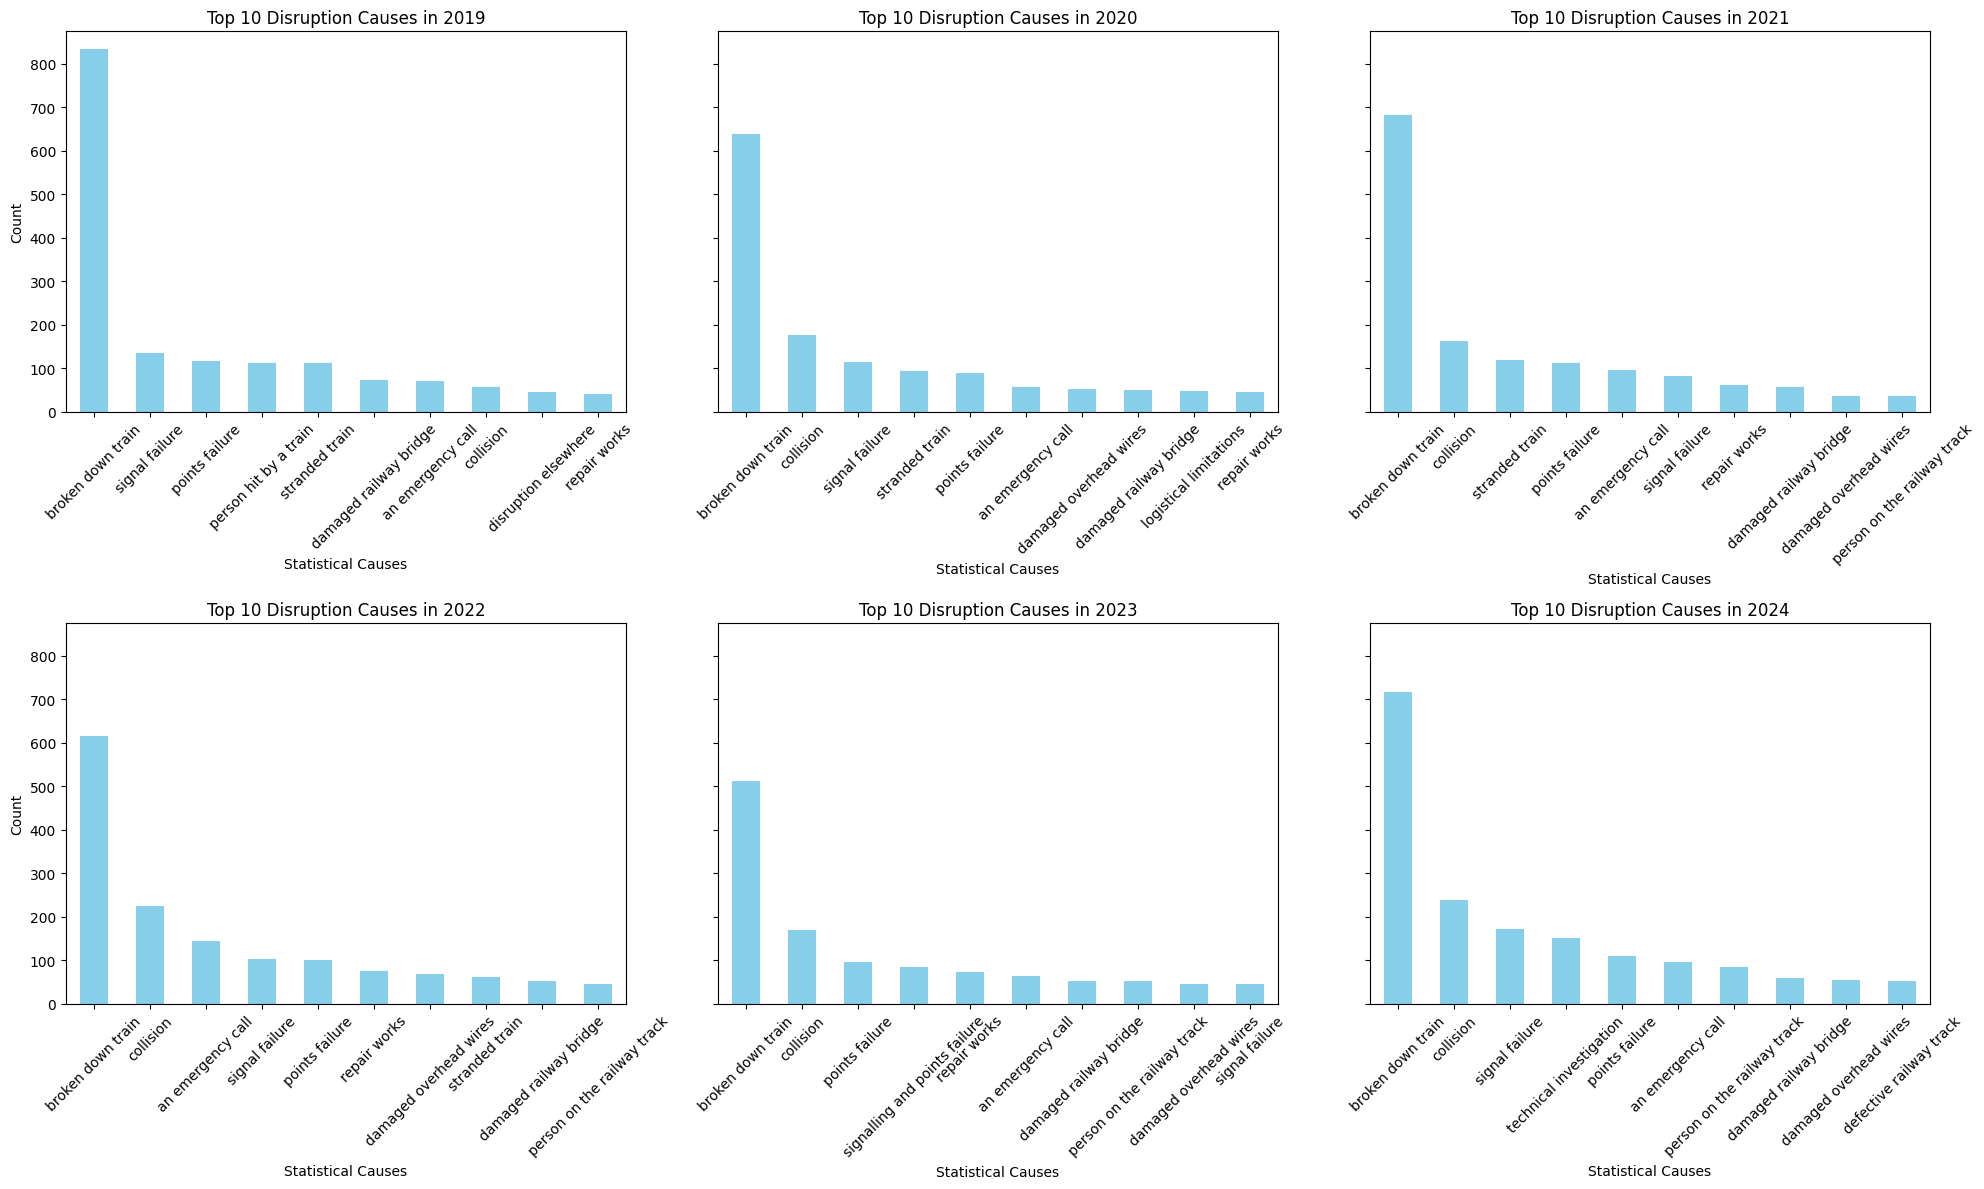

In [31]:
disrupted_df = disruptions_df[disruptions_df['Disrupted'] == True]
disrupted_df['Year'] = pd.to_datetime(disrupted_df['Date']).dt.year

# Explode the 'Statistical Causes' column to separate individual causes
disrupted_df_exploded = disrupted_df.copy()
disrupted_df_exploded = disrupted_df_exploded.explode('Statistical Causes')

# Group by year and cause, then count occurrences
causes_by_year = disrupted_df_exploded.groupby(['Year', 'Statistical Causes']).size().unstack(fill_value=0)

# Create subplots for all years in the same figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), sharey=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each year's data in a separate subplot
for i, year in enumerate(causes_by_year.index):
    ax = axes[i]
    causes_by_year.loc[year].nlargest(11).iloc[1:].sort_values(ascending=False).plot(kind='bar', color='skyblue', ax=ax)
    ax.set_title(f'Top 10 Disruption Causes in {year}')
    ax.set_xlabel('Statistical Causes')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

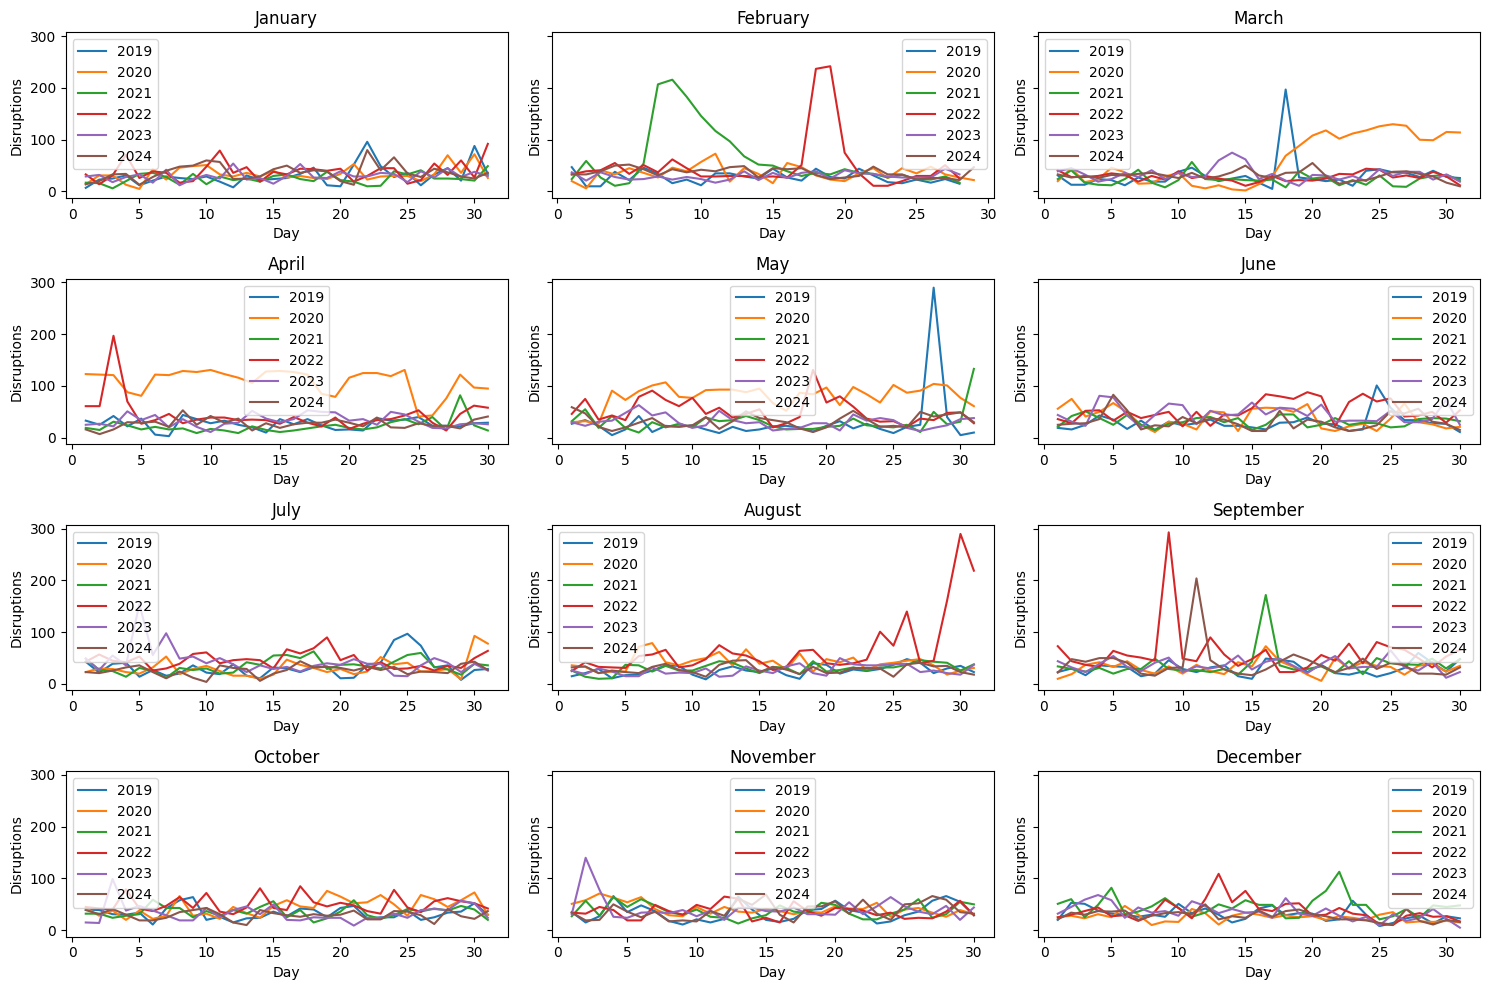

In [32]:
disruptions_df['Year'] = disruptions_df['Date'].dt.year
disruptions_df['Month'] = disruptions_df['Date'].dt.month
disruptions_df['Day'] = disruptions_df['Date'].dt.day
daily_by_year_month = disruptions_df.groupby(['Year', 'Month', 'Day'])['Disruption Count'].sum().unstack(fill_value=0)

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()
months = range(1, 13)
for i, month in enumerate(months):
    month_data = disruptions_df[disruptions_df['Date'].dt.month == month]
    for year in month_data['Year'].unique():
        year_month_data = month_data[month_data['Year'] == year]
        daily = year_month_data.groupby(year_month_data['Date'].dt.day)['Disruption Count'].sum()
        axes[i].plot(daily.index, daily.values, label=f'{year}')
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    axes[i].set_title(f'{months[month - 1]}')
    axes[i].set_xlabel('Day')
    axes[i].set_ylabel('Disruptions')
    axes[i].legend()
plt.tight_layout()
plt.show()

In [33]:
disruptions_by_year = disruptions_df.groupby('Year')[[ 'Disruption Count', 'Rides planned']].sum()
disruptions_by_year

,Disruption Count,Rides planned
Year,,
2019,10971.0,1482439
2020,17470.0,1554725
2021,12603.0,1480284
2022,17102.0,1567080
2023,12723.0,1412076
2024,11708.0,1493475


In [34]:
disruptions_by_month = disruptions_df.groupby('Month')['Disruption Count'].sum()
disruptions_by_month

Month
1     6041.0
2     6838.0
3     6429.0
4     7850.0
5     7882.0
6     6837.0
7     6647.0
8     6882.0
9     7035.0
10    7013.0
11    6869.0
12    6254.0
Name: Disruption Count, dtype: float64

In [35]:
# Assuming disruptions_df is already defined with 'Date' and 'Disruption Count' columns
disruptions_df['Year'] = disruptions_df['Date'].dt.year
disruptions_df['Month'] = disruptions_df['Date'].dt.month
disruptions_df['Day'] = disruptions_df['Date'].dt.day

# Define seasons based on date ranges
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month <= 3 and date.day <= 20):
        return 'Winter'
    elif (date.month == 3 and date.day >= 21) or (date.month <= 6 and date.day <= 20):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or (date.month <= 9 and date.day <= 20):
        return 'Summer'
    elif (date.month == 9 and date.day >= 21) or (date.month <= 12 and date.day <= 20):
        return 'Autumn'

disruptions_df['Season'] = disruptions_df['Date'].apply(get_season)
disruptions_by_season = disruptions_df.groupby('Season')[['Disruption Count', 'Rides planned']].sum()
disruptions_by_season['Proportion'] = disruptions_by_season['Disruption Count'] / disruptions_by_season['Rides planned']
disruptions_by_season

,Disruption Count,Rides planned,Proportion
Season,,,
Autumn,15703.0,1719680,0.009131
Spring,17666.0,1730142,0.010211
Summer,15024.0,1790431,0.008391
Winter,14414.0,1607318,0.008968


## Outliers

In [41]:
top_10_disruptions = disruptions_df.sort_values(by='Disruption Count', ascending=False)[['Date','source', 'target', 'Disruption Count']].head(10)
top_10_disruptions

,Date,source,target,Disruption Count
97240,2019-12-02,Amsterdam Centraal,Schiphol Airport,9.0
117997,2020-02-08,Amsterdam Centraal,Utrecht Centraal,7.0
489037,2023-07-05,Alkmaar,Amsterdam Centraal,7.0
96362,2019-11-29,Amsterdam Centraal,Utrecht Centraal,6.0
376979,2022-06-27,Amsterdam Centraal,Schiphol Airport,6.0
370671,2022-06-07,'s-Hertogenbosch,Utrecht Centraal,6.0
121446,2020-02-19,Amsterdam Centraal,Schiphol Airport,5.0
489737,2023-07-07,Amsterdam Centraal,Haarlem,5.0
80299,2019-10-08,Amsterdam Centraal,Schiphol Airport,5.0
71540,2019-09-09,Breda,Dordrecht,5.0


In [42]:
summed_disruptions = disruptions_df.groupby(['source', 'target'])[[ 'Rides planned', 'Disruption Count']].sum().reset_index()
summed_disruptions = summed_disruptions.sort_values(by='Disruption Count', ascending=False)

# Display the top 10 most disrupted trajectories
summed_disruptions.head(10)

,source,target,Rides planned,Disruption Count
3557,Rotterdam Centraal,Amsterdam Centraal,78784,1519.0
605,Amsterdam Centraal,Rotterdam Centraal,73825,1407.0
1939,Eindhoven Centraal,Den Haag Centraal,67331,1043.0
1457,Den Haag Centraal,Utrecht Centraal,36528,1019.0
620,Amsterdam Centraal,Utrecht Centraal,10012,978.0
57,'s-Hertogenbosch,Utrecht Centraal,34155,927.0
3628,Rotterdam Centraal,Utrecht Centraal,59027,898.0
1408,Den Haag Centraal,Eindhoven Centraal,65794,891.0
2942,Leiden Centraal,Utrecht Centraal,67595,876.0
1178,Breda,Amsterdam Centraal,53981,875.0


In [43]:
# Display the 10 least disrupted trajectories
no_disruptions = summed_disruptions[summed_disruptions['Disruption Count'] == 0]
no_disruptions = no_disruptions.sort_values(by='Rides planned', ascending=False)
no_disruptions.head(10)

,source,target,Rides planned,Disruption Count
38,'s-Hertogenbosch,Leiden Centraal,11865,0.0
3761,Schiedam Centrum,Rotterdam Blaak,3190,0.0
340,Amersfoort Centraal,Driebergen-Zeist,2817,0.0
1795,Driebergen-Zeist,Amersfoort Centraal,2780,0.0
3747,Schiedam Centrum,Delft Campus,2150,0.0
1354,Delft Campus,Schiedam Centrum,2102,0.0
1715,Dieren,Zwolle,1105,0.0
4774,Zwolle,Dieren,1097,0.0
3057,Maastricht,Roermond,1058,0.0
2918,Leiden Centraal,Heemstede-Aerdenhout,1016,0.0


### Adding Operational Features
- Days (with planned rides) since last disruption (int) </br>
- Total disruptions of this trajectory (int) </br>
- Total rides planned of this trajectory (int) </br>
- Total amount of previous disruptions (int) </br>

- Causes of previous disruptions (list) -onehot-> (array) </br>
- Cause(s) of most recent disruption (list) -onehot-> (array) </br>

In [44]:
# Calculate the value counts of 'Statistical Causes'
cause_counts = disrupted_df_exploded['Statistical Causes'].value_counts()
median = np.median(cause_counts)
st_dev = np.std(cause_counts)
print(median)
print(st_dev)

# Calculate the threshold for causes with counts less than 1.5 standard deviations from the median
high_threshold = median + 1.5 * st_dev
low_threshold = median - 1.5 * st_dev

# Filter causes that fall above this threshold
high_count_causes = cause_counts[cause_counts > high_threshold].index.tolist()

print(high_count_causes)

low_count_causes = cause_counts[cause_counts < low_threshold].index.tolist()
print(low_count_causes)

27.5
8152.411971862569
['Unspecified']
[]


In [45]:
disrupted_df

,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,TG,TN,TX,RHX,VVX,T10N,FHVEC,Disrupted,distance,Year
5,2019-01-01,'s-Hertogenbosch,Roosendaal,2,0,1,1,0,Unspecified,1.0,...,70.0,42.0,87.0,4.0,74.0,28.0,40.0,True,67.0,2019
6,2019-01-01,'s-Hertogenbosch,Utrecht Centraal,1,0,0,0,1,"[damaged overhead wires, an emergency call]",2.0,...,70.0,42.0,87.0,4.0,74.0,28.0,40.0,True,48.0,2019
72,2019-01-01,Den Haag Centraal,Eindhoven Centraal,32,4,1,1,18,Unspecified,1.0,...,78.0,58.0,91.0,3.0,76.0,50.0,52.0,True,131.0,2019
79,2019-01-01,Den Haag Centraal,Utrecht Centraal,21,2,1,0,4,[broken down train],1.0,...,78.0,58.0,91.0,3.0,76.0,50.0,52.0,True,60.0,2019
101,2019-01-01,Eindhoven Centraal,Den Haag Centraal,32,11,2,2,24,Unspecified,1.0,...,70.0,42.0,87.0,4.0,74.0,28.0,40.0,True,131.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654318,2024-12-31,Lelystad Centrum,Rotterdam Centraal,13,3,1,1,10,Unspecified,1.0,...,52.0,29.0,79.0,-1.0,80.0,29.0,82.0,True,127.0,2024
654361,2024-12-31,Rotterdam Centraal,Lelystad Centrum,15,1,2,2,5,Unspecified,1.0,...,51.0,30.0,84.0,1.0,68.0,30.0,80.0,True,127.0,2024
654363,2024-12-31,Rotterdam Centraal,Utrecht Centraal,61,11,1,1,37,[broken down train],1.0,...,51.0,30.0,84.0,1.0,68.0,30.0,80.0,True,56.0,2024
654379,2024-12-31,Uitgeest,Rotterdam Centraal,27,3,1,1,20,Unspecified,1.0,...,55.0,35.0,86.0,0.0,73.0,34.0,89.0,True,86.0,2024


In [65]:
# 1. Days since last disruption and total disruptions for each source-target pair
def days_since_last_disruption_per_pair(df):
    # Initialize columns
    df['Days_since_last_disruption'] = 0
    df['Num_prev_disruptions'] = 0
    df['Ratio'] = 0.0
    
    # Group by source and target
    grouped = df.groupby(['source', 'target'])
    
    for (source, target), group in grouped:
        # Get unique dates, disruption status, and sums
        date_disruption = group.groupby('Date').agg({
            'Disrupted': 'any',
            'Disruption Count': 'sum',
            'Rides planned': 'sum'
        }).reset_index()
        date_disruption['Date'] = pd.to_datetime(date_disruption['Date'])
        
        # Initialize variables
        days_with_rides = 0
        num_disruptions = 0
        total_rides = 0
        last_disruption_date = None
        days_since = []
        total_disr = []
        ratios = []
        
        # Process each unique date
        for _, row in date_disruption.iterrows():
            date = row['Date']
            is_disrupted = row['Disrupted']
            disruption_count = row['Disruption Count'] or 0
            rides_planned = row['Rides planned'] or 0
            
            # Append current cumulative disruptions and ratio (before updating)
            total_disr.append(num_disruptions)
            total_rides += rides_planned
            ratio = (num_disruptions / total_rides * 100) if total_rides > 0 else 0
            ratios.append(ratio)
            
            # Update days counter
            if last_disruption_date is not None:
                days_with_rides += 1
            days_since.append(days_with_rides)
            
            # Update disruption count and reset days if disrupted
            if is_disrupted:
                num_disruptions += disruption_count
                last_disruption_date = date
                days_with_rides = 0
        
        # Map values back to original group rows
        date_to_days = dict(zip(date_disruption['Date'], days_since))
        date_to_disr = dict(zip(date_disruption['Date'], total_disr))
        date_to_ratio = dict(zip(date_disruption['Date'], ratios))
        
        # Assign to DataFrame
        df.loc[group.index, 'Days_since_last_disruption'] = group['Date'].map(date_to_days)
        df.loc[group.index, 'Num_prev_disruptions'] = group['Date'].map(date_to_disr)
        df.loc[group.index, 'Ratio'] = group['Date'].map(date_to_ratio)
    
    return df

disruptions_df = days_since_last_disruption_per_pair(disruptions_df)

In [52]:
# 2. Total disruptions for each source-target pair
def total_disruptions_per_pair(df):
    # Initialize column
    df['Total_disruptions'] = 0
    
    # Group by source and target
    for (source, target), group in df.groupby(['source', 'target']):
        # Compute cumulative sum of disruptions for this pair
        cumsum_disruptions = group['Disruption Count'].cumsum()
        # Assign back to the DataFrame
        df.loc[group.index, 'Total_disruptions'] = cumsum_disruptions
        
    return df

disruptions_df = total_disruptions_per_pair(disruptions_df)

In [53]:
# 3. Total rides planned for each source-target pair
def total_rides_planned_per_pair(df):
    # Initialize column
    df['Total_rides'] = 0
    
    # Group by source and target
    for (source, target), group in df.groupby(['source', 'target']):
        # Compute cumulative sum of disruptions for this pair
        cumsum_disruptions = group['Rides planned'].cumsum()
        # Assign back to the DataFrame
        df.loc[group.index, 'Total_rides'] = cumsum_disruptions
        
    return df

disruptions_df = total_rides_planned_per_pair(disruptions_df)

In [66]:
disruptions_df

,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,distance,Days_since_last_disruption,Num_prev_disruptions,Previous_causes,Most_recent_causes,Previous_causes_vec,Most_recent_causes_vec,Total_disruptions,Total_rides,Ratio
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,[No Disruption],0.0,...,62.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0.000000
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,[No Disruption],0.0,...,108.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,33,0.000000
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,[No Disruption],0.0,...,54.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,17,0.000000
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,[No Disruption],0.0,...,73.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,11,0.000000
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,[No Disruption],0.0,...,32.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,18,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654431,2024-12-31,Zwolle,Nijmegen,1,0,0,0,1,[No Disruption],0.0,...,95.0,34,29,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,2972,0.975774
654432,2024-12-31,Zwolle,Roosendaal,31,5,6,0,28,[No Disruption],0.0,...,201.0,9,380,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",380,63841,0.595229
654433,2024-12-31,Zwolle,Schiphol Airport,1,0,0,0,0,[No Disruption],0.0,...,121.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,43,0.000000
654434,2024-12-31,Zwolle,Utrecht Centraal,29,1,0,0,19,[No Disruption],0.0,...,87.0,12,308,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",308,72843,0.422827


In [55]:
# Normalize Statistical Causes to always be a list
def normalize_causes(causes):
    if isinstance(causes, str):
        return [causes]
    if isinstance(causes, list):
        return causes
    return []

disruptions_df['Statistical Causes'] = disruptions_df['Statistical Causes'].apply(normalize_causes)

# 3 & 4. Causes of previous disruptions and most recent disruption
all_causes = set()
for causes in disruptions_df['Statistical Causes']:
    all_causes.update(causes)
all_causes = list(all_causes)

# 3 & 4. Causes of previous disruptions and most recent disruption, grouped by source-target
# Initialize columns
disruptions_df['Previous_causes'] = [[] for _ in range(len(disruptions_df))]
disruptions_df['Most_recent_causes'] = [[] for _ in range(len(disruptions_df))]


# Group by source and target
grouped = disruptions_df.groupby(['source', 'target'])

for (source, target), group in grouped:
    previous_causes = []
    most_recent_causes = []
    
    for i, (idx, row) in enumerate(group.iterrows()):
        if i == 0:
            disruptions_df.at[idx, 'Previous_causes'] = []
            disruptions_df.at[idx, 'Most_recent_causes'] = row['Statistical Causes'] if row['Disrupted'] else []
        else:
            disruptions_df.at[idx, 'Previous_causes'] = previous_causes.copy()
            disruptions_df.at[idx, 'Most_recent_causes'] = most_recent_causes.copy()
        
        if row['Disrupted']:
            current_causes = row['Statistical Causes']
            previous_causes.extend(current_causes)
            most_recent_causes = current_causes
    
    # Ensure Previous_causes is unique within the group
    disruptions_df.loc[group.index, 'Previous_causes'] = disruptions_df.loc[group.index, 'Previous_causes'].apply(lambda x: list(set(x)))

disruptions_df

,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,Disrupted,distance,Days_since_last_disruption,Num_prev_disruptions,Previous_causes,Most_recent_causes,Previous_causes_vec,Most_recent_causes_vec,Total_disruptions,Total_rides
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,[No Disruption],0.0,...,False,62.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,[No Disruption],0.0,...,False,108.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,33
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,[No Disruption],0.0,...,False,54.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,17
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,[No Disruption],0.0,...,False,73.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,11
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,[No Disruption],0.0,...,False,32.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654431,2024-12-31,Zwolle,Nijmegen,1,0,0,0,1,[No Disruption],0.0,...,False,95.0,34,29,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,2972
654432,2024-12-31,Zwolle,Roosendaal,31,5,6,0,28,[No Disruption],0.0,...,False,201.0,9,380,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",380,63841
654433,2024-12-31,Zwolle,Schiphol Airport,1,0,0,0,0,[No Disruption],0.0,...,False,121.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,43
654434,2024-12-31,Zwolle,Utrecht Centraal,29,1,0,0,19,[No Disruption],0.0,...,False,87.0,12,308,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",308,72843


In [56]:
causes = dict()
for cause in all_causes:
    causes[cause] = np.zeros(len(all_causes))
for i, cause in enumerate(all_causes):
    causes[cause][i] = 1

def causes_to_array(df):
    df['Previous_causes_vec'] = df['Previous_causes'].apply(lambda x: sum([causes[cause] for cause in x]) if len(x) > 0 else np.zeros(len(all_causes)))
    df['Most_recent_causes_vec'] = df['Most_recent_causes'].apply(lambda x: sum([causes[cause] for cause in x]) if len(x) > 0 else np.zeros(len(all_causes)))
    return df
disruptions_df = causes_to_array(disruptions_df)
disruptions_df

,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,Disrupted,distance,Days_since_last_disruption,Num_prev_disruptions,Previous_causes,Most_recent_causes,Previous_causes_vec,Most_recent_causes_vec,Total_disruptions,Total_rides
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,[No Disruption],0.0,...,False,62.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,[No Disruption],0.0,...,False,108.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,33
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,[No Disruption],0.0,...,False,54.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,17
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,[No Disruption],0.0,...,False,73.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,11
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,[No Disruption],0.0,...,False,32.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654431,2024-12-31,Zwolle,Nijmegen,1,0,0,0,1,[No Disruption],0.0,...,False,95.0,34,29,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,2972
654432,2024-12-31,Zwolle,Roosendaal,31,5,6,0,28,[No Disruption],0.0,...,False,201.0,9,380,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",380,63841
654433,2024-12-31,Zwolle,Schiphol Airport,1,0,0,0,0,[No Disruption],0.0,...,False,121.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,43
654434,2024-12-31,Zwolle,Utrecht Centraal,29,1,0,0,19,[No Disruption],0.0,...,False,87.0,12,308,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",308,72843


In [67]:
print(np.mean(disruptions_df['Ratio']))
print(np.std(disruptions_df['Ratio']))
disruptions_df

1.5456527840006353
2.3002004601658377


,Date,source,target,Rides planned,Final arrival delay,Final arrival cancelled,Completely cancelled,Intermediate arrival delays,Statistical Causes,Disruption Count,...,distance,Days_since_last_disruption,Num_prev_disruptions,Previous_causes,Most_recent_causes,Previous_causes_vec,Most_recent_causes_vec,Total_disruptions,Total_rides,Ratio
0,2019-01-01,'s-Hertogenbosch,Arnhem Centraal,1,0,0,0,1,[No Disruption],0.0,...,62.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1,0.000000
1,2019-01-01,'s-Hertogenbosch,Den Haag Centraal,33,4,2,0,27,[No Disruption],0.0,...,108.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,33,0.000000
2,2019-01-01,'s-Hertogenbosch,Deurne,17,4,1,0,11,[No Disruption],0.0,...,54.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,17,0.000000
3,2019-01-01,'s-Hertogenbosch,Dordrecht,11,0,0,0,3,[No Disruption],0.0,...,73.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,11,0.000000
4,2019-01-01,'s-Hertogenbosch,Eindhoven Centraal,18,2,0,0,7,[No Disruption],0.0,...,32.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,18,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654431,2024-12-31,Zwolle,Nijmegen,1,0,0,0,1,[No Disruption],0.0,...,95.0,34,29,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,2972,0.975774
654432,2024-12-31,Zwolle,Roosendaal,31,5,6,0,28,[No Disruption],0.0,...,201.0,9,380,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",380,63841,0.595229
654433,2024-12-31,Zwolle,Schiphol Airport,1,0,0,0,0,[No Disruption],0.0,...,121.0,0,0,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,43,0.000000
654434,2024-12-31,Zwolle,Utrecht Centraal,29,1,0,0,19,[No Disruption],0.0,...,87.0,12,308,[Unspecified],[Unspecified],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",308,72843,0.422827


In [ ]:
never_disrupted = disruptions_df[disruptions_df['Total_disruptions'] == 0]
print(never_disrupted)
print("Mean and median of rides planned for never disrupted trajectories:")
print(np.mean(never_disrupted['Total_rides']))
print(np.median(never_disrupted['Total_rides']))
print("Mean and median of rides planned for disrupted trajectories:")
print(np.mean(disruptions_df[disruptions_df['Total_disruptions'] > 0]['Total_rides']))
print(np.median(disruptions_df[disruptions_df['Total_disruptions'] > 0]['Total_rides']))
print("Percentage of never disrupted trajectories:")
bla = 37637 / 612790 * 100
print(bla)

             Date            source              target  Rides planned  \
0      2019-01-01  's-Hertogenbosch     Arnhem Centraal              1   
1      2019-01-01  's-Hertogenbosch   Den Haag Centraal             33   
2      2019-01-01  's-Hertogenbosch              Deurne             17   
3      2019-01-01  's-Hertogenbosch           Dordrecht             11   
4      2019-01-01  's-Hertogenbosch  Eindhoven Centraal             18   
...           ...               ...                 ...            ...   
654328 2024-12-31        Maastricht    Utrecht Centraal              2   
654371 2024-12-31  Schiphol Airport              Zwolle              2   
654399 2024-12-31              Velp             Zutphen              1   
654404 2024-12-31             Venlo    Utrecht Centraal              1   
654433 2024-12-31            Zwolle    Schiphol Airport              1   

        Final arrival delay  Final arrival cancelled  Completely cancelled  \
0                         0      

In [76]:
operational_cols = ['Date', 'source', 'target', 'Days_since_last_disruption', 'Num_prev_disruptions', 'Ratio', 'Total_disruptions', 'Total_rides', 'Previous_causes_vec', 'Most_recent_causes_vec']
operational_df = disruptions_df[operational_cols]
operational_df.set_index('Date', inplace=True)
operational_df.to_csv('operational_dataset.csv', index=True)

### Pearson's Correlation Between Variables

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Select weather-related features
weather_features = ['RH', 'SQ', 'TG', 'TN', 'TX', 'RHX', 'VVX', 'T10N', 'FHVEC']
weather_data = disruptions_df[weather_features].dropna()

# Clean the data: strip spaces and coerce non-numeric values to NaN
weather_data = weather_data.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
weather_data = weather_data.apply(pd.to_numeric, errors='coerce').dropna()
# Standardize the data
scaler = StandardScaler()
weather_data_scaled = scaler.fit_transform(weather_data)

# Add the 'Disrupted' column and other specified columns to the weather data for correlation analysis
columns_to_add = ['Rides planned', 'Final arrival delay', 'Final arrival cancelled', 'Completely cancelled', 'Intermediate arrival delays','distance', 'Disruption Count']
for column in columns_to_add:
    weather_data[column] = disruptions_df.loc[weather_data.index, column].astype(float)

# Compute Pearson's correlation coefficients
correlation_matrix = weather_data.corr(method='pearson')[['Disruption Count']]
print(correlation_matrix)

C:\Users\brake\AppData\Local\Temp\ipykernel_11712\604010676.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weather_data = weather_data.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


                             Disruption Count
RH                                  -0.000817
SQ                                   0.034173
TG                                   0.005943
TN                                  -0.003640
TX                                   0.012035
RHX                                 -0.003431
VVX                                  0.018111
T10N                                -0.005389
FHVEC                                0.016874
Rides planned                        0.265249
Final arrival delay                  0.196137
Final arrival cancelled              0.305862
Completely cancelled                 0.293964
Intermediate arrival delays          0.170235
distance                            -0.052344
Disruption Count                     1.000000


### Graph of the overall Network with all  Possible Edges

In [13]:
import plotly.graph_objects as go
import networkx as nx

sources = disruptions_df['source'].unique()
coordinates_df = pd.read_csv('stations-2023-09-nl.csv')
destinations = disruptions_df['target'].unique()
stations = list(set(sources).union(set(destinations)))
edges = disruptions_df[['source', 'target']].values

G = nx.Graph()
G.add_nodes_from(stations)
G.add_edges_from(edges)

# Create a Plotly figure
# Filter coordinates_df to include only stations present in the graph
coordinates_df = coordinates_df[coordinates_df['name_long'].isin(G.nodes())]

# Create a dictionary of positions based on coordinates
pos = {row['name_long']: (row['geo_lng'], row['geo_lat']) for _, row in coordinates_df.iterrows()}

# Remove nodes from the graph that are not in the coordinates_df
nodes_to_remove = [node for node in G.nodes() if node not in pos]
G.remove_nodes_from(nodes_to_remove)

# Extract edge positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Extract node positions and attributes
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title=dict(
                text='Node Connections',
                side='right'
            ),
            xanchor='left'
        )
    )
)

# Add node text
node_adjacencies = []
node_text = []
for node, adjacencies in G.adjacency():
    node_adjacencies.append(len(adjacencies))
    node_text.append(f'{node}<br># of connections: {len(adjacencies)}')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network Graph',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()

![alt text](total_plot.png "Total Graph Plot")

# Creating a Daily Graph with Network Features

In [11]:
# Get unique dates and stations
unique_dates = disruptions_df['Date'].dt.date.unique()
sources = disruptions_df['source'].unique()
destinations = disruptions_df['target'].unique()
stations = list(set(sources).union(set(destinations)))

# Function to create daily graph and calculate node features
def create_daily_graph(date, df):
    # Filter data for the specific date
    daily_df = df[df['Date'].dt.date == date]
    
    # Create graph
    G = nx.DiGraph()
    G.add_nodes_from(stations)
    
    # Add weighted edges
    for _, row in daily_df.iterrows():
        G.add_edge(
            row['source'], 
            row['target'], 
            weight=row['Rides planned'], 
            distance=row['distance']
        )
        # print(f"Added edge from {row['source']} to {row['target']} with weight {row['Rides planned']} and distance {row['distance']}")
    
    # Calculate node features
    node_features = {}
    for node in G.nodes():
        # Degree (number of connections)
        degree = G.degree(node)
        
        # Weighted degree (sum of rides planned)
        weighted_degree = sum(
            G[node][neighbor]['weight'] 
            for neighbor in G.neighbors(node)
        )
        
        # Average distance to neighbors
        avg_distance = (
            sum(G[node][neighbor]['distance'] for neighbor in G.neighbors(node)) / degree
            if degree > 0 else 0
        )
        
        node_features[node] = {
            'degree': degree,
            'weighted_degree': weighted_degree,
            'avg_distance': avg_distance
        }
    # Calculate edge features
    edge_features = {}
    for edge in G.edges():
        source, target = edge
        
        # Convert directed graph to undirected graph for compatibility with certain metrics
        G_undirected = G.to_undirected()
        
        # Number of common neighbors
        common_neighbors = len(list(nx.common_neighbors(G_undirected, source, target)))
        
        # Jaccard coefficient (ratio of common neighbors to total unique neighbors)
        jaccard = list(nx.jaccard_coefficient(G_undirected, [(source, target)]))[0][2]
        
        # Preferential attachment (product of degrees)
        pref_attachment = G.degree(source) * G.degree(target)
        
        # Adamic-Adar index (weighted common neighbors by inverse log of degree)
        adamic_adar = list(nx.adamic_adar_index(G_undirected, [(source, target)]))[0][2]
        
        # Resource allocation index (similar to Adamic-Adar but simpler weighting)
        resource_allocation = list(nx.resource_allocation_index(G_undirected, [(source, target)]))[0][2]
        
        # Edge weight (rides planned)
        weight = G[source][target]['weight']
        
        # Edge distance
        distance = G[source][target]['distance']
        
        edge_features[edge] = {
            'common_neighbors': common_neighbors,
            'jaccard_coefficient': jaccard,
            'preferential_attachment': pref_attachment,
            'adamic_adar_index': adamic_adar,
            'resource_allocation_index': resource_allocation,
            'weight': weight,
            'distance': distance
        }
    
    return G, node_features, edge_features

example_date = unique_dates[0]
G, node_features, edge_features = create_daily_graph(example_date, disruptions_df)
daily_df = disruptions_df[disruptions_df['Date'].dt.date == example_date]

In [12]:
# Dictionary to store daily graphs and features
daily_graphs = {}
daily_features = {}
daily_edge_features = {}

# Process each day
for date in unique_dates:
    G, features, edge_features = create_daily_graph(date, disruptions_df)
    daily_graphs[date] = G
    daily_features[date] = features
    daily_edge_features[date] = edge_features

# Example Graph for the First Day of the Dataset

In [ ]:

# Example: Visualize graph for a specific date
def visualize_graph(date, G):  # Position nodes
    
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    node_x = []
    node_y = []
    for node in G.nodes():
        if node not in pos:
            node_x.append(5.5)
            node_y.append(52)
            continue
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title=dict(
                    text='Node Connections',
                    side='right'
                ),
                xanchor='left'
            )
        )
    )
    
    # Add node information
    node_text = []
    node_colors = []
    features = daily_features[date]
    for node in G.nodes():
        info = (f"Station: {node}<br>"
                f"Degree: {features[node]['degree']}<br>"
                f"Rides: {features[node]['weighted_degree']}<br>"
                f"Avg Distance: {features[node]['avg_distance']:.2f}")
        node_text.append(info)
        node_colors.append(features[node]['weighted_degree'])
    
    node_trace.text = node_text
    node_trace.marker.color = node_colors
    
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=f'Train Network - {date}',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
        )
    )
    
    fig.show()

# Visualize for a specific date (example)
example_date = unique_dates[0]
visualize_graph(example_date, daily_graphs[example_date])

# # Print features for first date as example
# print(f"Node features for {example_date}:")
# for edge, features in daily_edge_features[example_date].items():
#     print(f"{node}: {features}")

In [ ]:
# Visualize for a specific date (example)
example_date = unique_dates[0]
visualize_graph(example_date, daily_graphs[example_date])

# Print features for first date as example
print(f"Node features for {example_date}:")
for edge, features in daily_edge_features[example_date].items():
    print(f"{edge}: {features}")

Node features for 2019-01-01:
('Amersfoort Schothorst', 'Den Haag Centraal'): {'common_neighbors': 2, 'jaccard_coefficient': 0.10526315789473684, 'preferential_attachment': 145, 'adamic_adar_index': 0.7578099350519243, 'resource_allocation_index': 0.14545454545454545, 'weight': 16, 'distance': 84.0}
('Amersfoort Schothorst', 'Schiphol Airport'): {'common_neighbors': 2, 'jaccard_coefficient': 0.18181818181818182, 'preferential_attachment': 85, 'adamic_adar_index': 0.669491709409866, 'resource_allocation_index': 0.10101010101010101, 'weight': 16, 'distance': 58.0}
('Amersfoort Schothorst', 'Utrecht Centraal'): {'common_neighbors': 2, 'jaccard_coefficient': 0.08695652173913043, 'preferential_attachment': 180, 'adamic_adar_index': 0.7802707381644454, 'resource_allocation_index': 0.15555555555555556, 'weight': 1, 'distance': 24.0}
('Hilversum', 'Utrecht Centraal'): {'common_neighbors': 1, 'jaccard_coefficient': 0.043478260869565216, 'preferential_attachment': 108, 'adamic_adar_index': 0.303

![alt text](daily_plot.png "Daily Graph Plot")


In [ ]:
# Prepare feature dataset
feature_data = []
target = []
dates = []

for date in first_month_dates:
    daily_df = first_month_df[first_month_df['Date'].dt.date == date]
    features = daily_features[date]
    edge_features = daily_edge_features[date]
    
    # For each source-target pair in the daily data
    for _, row in daily_df.iterrows():
        source = row['source']
        destination = row['target']
        disrupted = row['Disrupted']
        
        # Combine features from source and target nodes
        combined_features = [
            row['source'],
            row['target'],
            features[source]['degree'],
            features[source]['weighted_degree'],
            features[source]['avg_distance'],
            features[destination]['degree'],
            features[destination]['weighted_degree'],
            features[destination]['avg_distance'],
            edge_features[(source, destination)]['common_neighbors'],
            edge_features[(source, destination)]['jaccard_coefficient'],
            edge_features[(source, destination)]['preferential_attachment'],
            edge_features[(source, destination)]['adamic_adar_index'],
            edge_features[(source, destination)]['resource_allocation_index'],
            edge_features[(source, destination)]['weight'],
            edge_features[(source, destination)]['distance'],
            row['RH'], row['SQ'], row['TG'], row['TN'], row['TX'], row['RHX'], row['VVX'], row['T10N'], row['FHVEC']
        ]
        
        # Replace NaN values in combined_features with 0
        combined_features = [0 if pd.isna(value) else value for value in combined_features]
        
        feature_data.append(combined_features)
        target.append(disrupted)
        dates.append(date)

# Convert to a DataFrame
columns = [
    'source', 'destination', 'source_degree', 'source_weighted_degree', 'source_avg_distance',
    'target_degree', 'target_weighted_degree', 'target_avg_distance',
    'common_neighbors', 'jaccard_coefficient', 'preferential_attachment',
    'adamic_adar_index', 'resource_allocation_index', 'weight', 'distance',
    'RH', 'SQ', 'TG', 'TN', 'TX', 'RHX', 'VVX', 'T10N', 'FHVEC'
]
features_df = pd.DataFrame(feature_data, columns=columns)
features_df['Date'] = dates
features_df['Disrupted'] = target

# Display the resulting DataFrame
features_df.head()

,source,destination,source_degree,source_weighted_degree,source_avg_distance,target_degree,target_weighted_degree,target_avg_distance,common_neighbors,jaccard_coefficient,...,SQ,TG,TN,TX,RHX,VVX,T10N,FHVEC,Date,Disrupted
0,'s-Hertogenbosch,Arnhem Centraal,14,83,31.714286,14,65,33.714286,3,0.230769,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,2019-01-01,False
1,'s-Hertogenbosch,Den Haag Centraal,14,83,31.714286,29,253,52.793103,3,0.130435,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,2019-01-01,False
2,'s-Hertogenbosch,Deurne,14,83,31.714286,3,17,18.000000,1,0.111111,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,2019-01-01,False
3,'s-Hertogenbosch,Dordrecht,14,83,31.714286,18,116,36.555556,4,0.307692,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,2019-01-01,False
4,'s-Hertogenbosch,Eindhoven Centraal,14,83,31.714286,21,116,40.142857,2,0.111111,...,7.0,70.0,42.0,87.0,4.0,74.0,28.0,40.0,2019-01-01,False


In [16]:
# Save the features DataFrame to a CSV file	
features_df.to_csv('feature_data.csv', index=False)